# Case study

written by Abdullahi Adinoyi Ibrahim

## Task
Predict income and expenses for a holdout sample of ~10K users for the month of August based on a training sample of ~10K users from Februrary through July.

Based on your judgement of the usefulness of the results, either aggregate the data into incoming & outgoing flows, or predict based on the transaction type/category.


In [9]:
'''
----------------------
library
----------------------
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
import joblib
import os

# custom modules
from LRmodel import LogisticRegressionModels
import plotter
import preprocessing


### Loading the dataset

In [66]:
'''
----------------------
Data loading
----------------------
'''
# data_train = pd.read_csv('./data/2016-09-19_79351_training.csv')
data_train = pd.read_csv("./data/2016-09-19_79351_training_feb_june.csv")
data_mcc_group = pd.read_csv('./data/mcc_group_definition.csv')
data_transaction = pd.read_csv('./data/transaction_types.csv')


# Data wrangling

In [67]:
'''
----------------------
copy data
----------------------
'''
data_train_main = data_train.copy()

In [68]:
'''
----------------------
view head
----------------------
'''
data_train_main.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,01.02.16,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,01.02.16,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,01.02.16,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,01.02.16,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,01.02.16,DT,NaN,272,training,training


In [69]:
'''
----------------------
data info
----------------------
'''
data_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337560 entries, 0 to 337559
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              337560 non-null  object 
 1   transaction_date     337560 non-null  object 
 2   transaction_type     337560 non-null  object 
 3   mcc_group            213233 non-null  float64
 4   amount_n26_currency  337560 non-null  int64  
 5   dataset_transaction  337560 non-null  object 
 6   dataset_user         337560 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 18.0+ MB


The features `dataset_transaction` and  `dataset_user` contains only one unique entry which are irrelevant. We simply drop them. 

In [70]:
'''
----------------------
dropping columns
----------------------
'''
data_train_main = data_train_main.drop(['dataset_transaction', 'dataset_user'], axis=1)

In [71]:
'''
----------------------
how many missing values?
----------------------
'''
data_train_main.isna().sum()    

user_id                     0
transaction_date            0
transaction_type            0
mcc_group              124327
amount_n26_currency         0
dtype: int64

In [72]:
'''
----------------------
percentage of missing values
----------------------
'''
data_train_main.isna().sum()[data_train_main.isna().sum() > 0][0] / len(data_train_main) * 100

36.83108188173954

## To do
 - create ```direction``` (i.e. in/out) feature: the ```in``` and ```out``` represents the income and expenses, respectively. ```in``` denotes money coming into the user acccount and ```out``` denotes money going out of the user account.

 - creating month/day feature from the transaction date.

 - fill NAs in ```mcc_group``` with mode and miscellaneous. We will fill the NAs locally per user. Specifically, we will take the ```mcc_group``` of a user and check for the most frequent transaction type and use this mode to replace any NA for such user. In the event there is no mode, we will simply categorize this as miscellaneous (i.e. 16) since no modal value.

In [73]:
'''
----------------------
filtered data_transaction based in transaction_type
----------------------
'''

selected_types = list(data_train_main.transaction_type.unique()); selected_types
data_transaction_filtered = data_transaction[data_transaction.type.isin(selected_types)]

data_transaction_filtered.reset_index(drop = True, inplace = True); data_transaction_filtered

,type,explanation,direction,agent
0,BBU,Cash26 deposit,In,Partner
1,CT,Credit Transfer,In,Bank Account
2,DR,Debit Reversal,In,Bank Account
3,BUB,Cash26 withdrawal,Out,Partner
4,DD,Direct Debit,Out,Bank Account
5,DT,Debit Transfer,Out,Bank Account
6,FT,MoneyBeam Transfer,Out,Bank Account
7,PT,Presentment,Out,Card
8,TUB,Transferwise Transaction,Out,Partner


In [74]:
'''
----------------------
Grouping the transaction type into in and out
----------------------
'''
type_in = data_transaction_filtered[data_transaction_filtered.direction == 'In'].type
type_out = data_transaction_filtered[data_transaction_filtered.direction == 'Out'].type
type_in, type_out = list(type_in), list(type_out); 
type_in, type_out

(['BBU', 'CT', 'DR'], ['BUB', 'DD', 'DT', 'FT', 'PT', 'TUB'])

In [75]:
'''
----------------------
 adding in/out feature to data_train_main
----------------------
'''

data_train_main['direction'] = data_train_main.transaction_type.apply(lambda x: 'In' if x in type_in else 'Out')

In [76]:
'''
----------------------
 mapping and adding agent feature to data_train_main
----------------------
'''
type_to_agent = {
    'BBU': 'Partner',
    'CT': 'Bank Account',
    'DR': 'Bank Account',
    'PF': 'Card',
    'PT': 'Card',
    'BUB': 'Partner',
    'DD': 'Bank Account',
    'DT': 'Bank Account',
    'FT': 'Bank Account',
    'TUB': 'Partner'
}

data_train_main['agent'] = data_train_main.transaction_type.apply(lambda x: type_to_agent[x])

In [77]:
'''
----------------------
quick check on the data_train_main
----------------------
'''

data_train_main[data_train_main.transaction_type == 'PT']

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent
526,bf84257bf1b24c4cd05bae3f5ab14b0f,01.02.16,PT,4.0,15,Out,Card
528,86c37c519ed3516d079fc687c9357eb9,01.02.16,PT,7.0,4,Out,Card
531,9fed9cf27088374646d08b2356783c25,01.02.16,PT,2.0,6,Out,Card
532,9fed9cf27088374646d08b2356783c25,01.02.16,PT,2.0,4,Out,Card
535,2d907dc31f7432c76d3700f9044fa562,01.02.16,PT,8.0,17,Out,Card
...,...,...,...,...,...,...,...
337038,9d58b8d99ce87647e156c1c6b80f535c,30.06.16,PT,12.0,7,Out,Card
337039,a71164041a6a1210f0ee2b30c6b24148,30.06.16,PT,12.0,194,Out,Card
337040,58ca84e181b7a63c24f685f4c4e04bc5,30.06.16,PT,1.0,38,Out,Card
337041,2331ec0969b65cfaa3c8df16a3cd5ec7,30.06.16,PT,1.0,70,Out,Card


In [78]:
'''
----------------------
extract day/month from data_train_main.transaction_date
----------------------
'''

data_train_main['transaction_date'] = pd.to_datetime(data_train_main.transaction_date)
data_train_main['day'] = data_train_main.transaction_date.dt.day
data_train_main['month'] = data_train_main.transaction_date.dt.month

<ipython-input-78-e63252eb7773>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_train_main['transaction_date'] = pd.to_datetime(data_train_main.transaction_date)


### Filling in the missing values in mcc_group feature

![title](./img/na_fill.png)


As shown above, we filled the NAs locally per user. Specifically, we take the ```mcc_group``` of a user and check for the most frequent transaction type and use this mode to replace any NA for such user. In the event there is no mode, we simply categorize this as miscellaneous (i.e. 16) since no modal value.

In [79]:
'''
----------------------
Function to fill missing values with mode or miscellaneous
----------------------
'''

def fill_missing_with_mode(df, group_col, target_col):
    
    def mode_function(x):
        modes = x.mode()
        if not modes.empty:
            return modes[0]
        else:
            return 16 #miscellaneous
    
    df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(mode_function(x)))
    
    return df


data_train_main_filled = fill_missing_with_mode(data_train_main, 'user_id', 'mcc_group')


In [80]:
'''
----------------------
Testing the result for a user
----------------------
'''

[data_train_main_filled['user_id']=='001f9baedaf3c8487c344d25b0eda9fc']

[0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 337555    False
 337556    False
 337557    False
 337558    False
 337559    False
 Name: user_id, Length: 337560, dtype: bool]

<Axes: xlabel='mcc_group'>

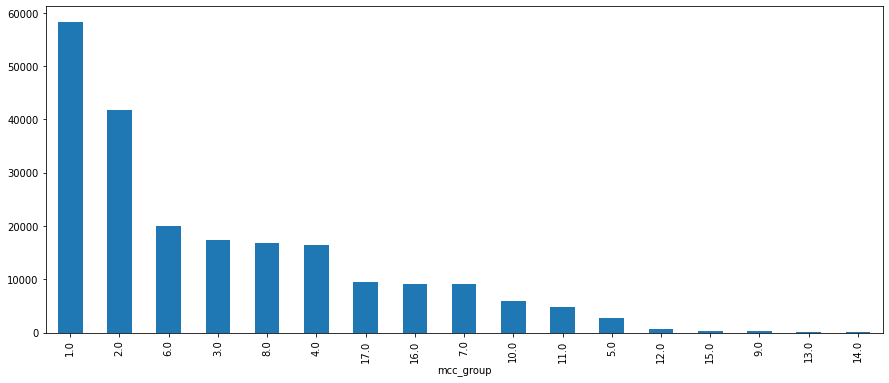

In [81]:
'''
----------------------
Distribution of mcc_group before filling NAs
----------------------
'''

plt.figure(figsize=(15, 6))
data_train.mcc_group.value_counts().plot(kind = 'bar')

<Axes: xlabel='mcc_group'>

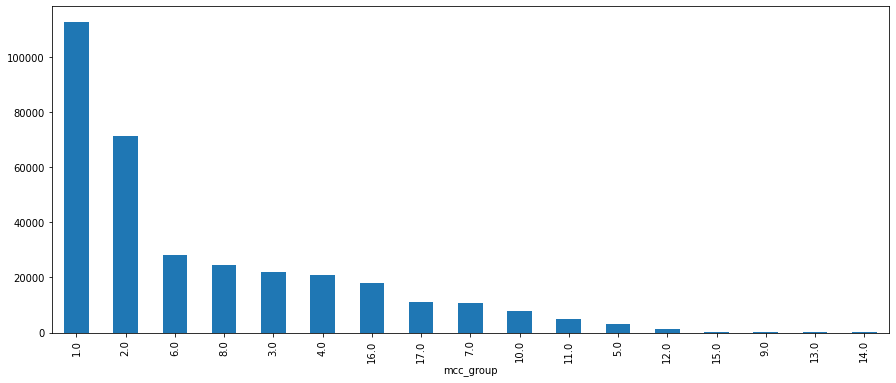

In [82]:
'''
----------------------
Distribution of mcc_group after fill
----------------------
'''

plt.figure(figsize=(15, 6))
data_train_main_filled.mcc_group.value_counts().plot(kind = 'bar')

# checking distribution of response feature

<Axes: xlabel='direction'>

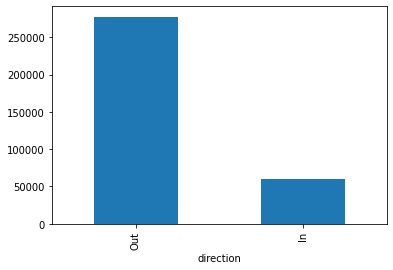

In [83]:
'''
----------------------
Distribution of direction
----------------------
'''

data_train_main_filled.direction.value_counts().plot(kind = 'bar')

The plot shows that the target variable `direction` is imbalanced. With income accounting for 18% and expenses 82%. 

In [84]:
'''
----------------------
percentage distribution of direction
----------------------
'''

data_train_main_filled.direction.value_counts(normalize=True) * 100

direction
Out    82.196647
In     17.803353
Name: proportion, dtype: float64

## Feature engineering

In [85]:
'''
----------------------
encoding categorical columns
----------------------
'''

categorical_cols = data_train_main_filled.select_dtypes(include = 'object').columns
print(f'categorical_cols:{categorical_cols}')
for col in categorical_cols[:]:
    data_train_main_filled[col] = LabelEncoder().fit_transform(data_train_main_filled[col])



# set mcc_group into integer

data_train_main_filled['mcc_group'] = data_train_main_filled['mcc_group'].astype(int)

categorical_cols:Index(['user_id', 'transaction_type', 'direction', 'agent'], dtype='object')


In [86]:
data_train_main_filled.direction.value_counts()

direction
1    277463
0     60097
Name: count, dtype: int64

In [87]:
'''
----------------------
view of the updated data
----------------------
'''

data_train_main_filled.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
0,6402,2016-01-02,5,8,350,1,0,2,1
1,6751,2016-01-02,5,7,202,1,0,2,1
2,4763,2016-01-02,5,1,291,1,0,2,1
3,7826,2016-01-02,5,1,214,1,0,2,1
4,2863,2016-01-02,5,17,272,1,0,2,1


In [88]:
'''
----------------------
Dropping transaction_date, transaction_type, user_id
----------------------
'''

data_train_main_filled.drop(['transaction_date', 'transaction_type'], axis=1, inplace=True)


In [89]:
'''
----------------------
correlation check
----------------------
'''

data_train_main_filled.corr()

,user_id,mcc_group,amount_n26_currency,direction,agent,day,month
user_id,1.000000,0.002752,0.000511,-0.002387,-0.008609,0.005233,0.002302
mcc_group,0.002752,1.000000,-0.063145,0.058669,0.100982,-0.005984,0.012564
amount_n26_currency,0.000511,-0.063145,1.000000,-0.357703,-0.283742,0.046683,-0.034658
direction,-0.002387,0.058669,-0.357703,1.000000,0.514057,-0.016038,0.034238
agent,-0.008609,0.100982,-0.283742,0.514057,1.000000,0.004547,0.064605
day,0.005233,-0.005984,0.046683,-0.016038,0.004547,1.000000,-0.327059
month,0.002302,0.012564,-0.034658,0.034238,0.064605,-0.327059,1.000000


## splitting

In [90]:
'''
----------------------
split data
----------------------
'''

X = data_train_main_filled.drop('direction', axis=1)
y = data_train_main_filled['direction']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [91]:
'''
----------------------
Checking the proportion of the classes in the train, validation and test sets
----------------------
'''

y_train.value_counts(normalize=True) * 100, y_val.value_counts(normalize=True) * 100, y_test.value_counts(normalize=True) * 100

(direction
 1    82.196498
 0    17.803502
 Name: proportion, dtype: float64,
 direction
 1    82.19872
 0    17.80128
 Name: proportion, dtype: float64,
 direction
 1    82.195758
 0    17.804242
 Name: proportion, dtype: float64)

In [92]:
'''
----------------------
grids search on RF
----------------------
'''

run_grid_search = False
if run_grid_search:
    
    param_grid = {
        'class_weight': [{0: 1.3, 1: 1.0},{0: 1.4, 1: 1.0}, {0: 1.45, 1: 1.0}, {0: 1.5, 1: 1.0}],
        # 'class_weight': [{0: 2.8, 1: 0.6}, {0: 2.4, 1: 0.6},  {0: 2.2, 1: 0.6}],
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
    }
    

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=3, verbose=3)
   
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_;best_params
    print("Best parameters:", best_params)

# Methods

![title](./img/lr.png)
## 1. LR (logistic regression): 
we use the LR methods as baseline and in addition, we add penalties to the cost function to balance the target variable.

## 2. RF (random forest)

![title](./img/rfTree.png)
`(image source: https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png)`

In classification problem, the RF method works by constructing multiple decision trees during training and returns the majority vote from these trees.

baseline RF assumes equal importance for all classes, and the weighted approach introduces class weights to modify the splitting criteria of the labels to prioritize minority class.

## 3. MLP (multilayer perceptron)
mlp is a feedforward neural network consisting of fully connected neurons with nonlinear activation functions 





paramter:

- `class_weight`: in the weighted RF, changes to `class_weight` will modify the outcome of the model. after some experiments, the class weight is set as `class_weight={0:1.45, 1:1.0}`
- `max_depth`: the maximum depth of the tree
- `n_estimator`: higher (lower) `n_estimator` could increase (reduce) model accuracy
- weights on LR: to tune the model sensitivity to imbalanced response feature, use `weight_positive=1.` and  `weight_negative=1.45`. these values are thesame as in `class_weight`
- `hidden_layer_sizes`: The ith element represents the number of neurons in the ith hidden layer.
- `activation`: activation function for the hidden layer. other options are {identity, logistic, tanh}.
- `solver`: the solver for weight optimization. other options to try are `lbfgs` and `sgd`.

In [ ]:
'''
----------------------
train model
----------------------
'''

n_estimator = 100
seedS = 42
lr = 0.01
max_iter = 1000
max_depth = 15

models = {
    # "Baseline RF": RandomForestClassifier(n_estimators=n_estimator, random_state=seedS),
    "Weighted RF": RandomForestClassifier(n_estimators=n_estimator, class_weight={0:1.45, 1:1.0}, max_depth=max_depth, random_state=seedS),
    # "Baseline LR": LogisticRegressionModels(model_type="baseline", learning_rate=lr, max_iter=max_iter),
    # "cost LR": LogisticRegressionModels(model_type="cost_sensitive", weight_positive=1., weight_negative=1.45, learning_rate=lr, max_iter=max_iter),
    # "MLP": MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', verbose=False,learning_rate_init=lr, max_iter=max_iter, random_state=seedS),
} 

results = {}
for name, model in models.items():
    print(f"Training {name}")
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        model.fit(X_train, y_train)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        model.fit(X_train, y_train, X_val, y_val)
    else:
        raise ValueError("Model not supported")
        
    show_curves = False
    if show_curves:
        if isinstance(model, (LogisticRegressionModels)):  
            plt.figure(figsize=(10, 6))
            plt.plot(model.train_losses, label='Training Loss')
            plt.plot(model.val_losses, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid()
            plt.show()

    # pred
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    '''
    X_new_data = new_data.drop('direction', axis=1)
    y_new = new_data['direction']
    y_pred_new_data = model.predict(X_new_data)
    
    test_accuracy_new = accuracy_score(y_new, y_pred_new_data)'''

    # metric
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # y_pred_proba_new_data = model.predict_proba(X_new_data)[:, 1]

        auc = roc_auc_score(y_test, y_pred_proba_test)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        y_pred_proba_test = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba_test)

    results[name] = {
        "Train Accuracy": train_accuracy,
        "Val Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        # 'new data': test_accuracy_new,
        "AUC": auc,
        "f1": f1,
        "Model": model,
        }
    print(f"--- {name} saved ---")
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Val Accuracy: {val_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

Training Weighted RF


/Users/abdullahi/opt/anaconda3/envs/abdulGeneral/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/abdullahi/opt/anaconda3/envs/abdulGeneral/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


--- Weighted RF saved ---
Train Accuracy: 0.91
Val Accuracy: 0.88
Test Accuracy: 0.88


In [ ]:
'''
----------------------
Check test accuracy
----------------------
'''

methods = list(results.keys())
test_accuracies_ = [metrics['Test Accuracy'] for metrics in results.values()]

list(zip(methods,test_accuracies_))

In [ ]:
'''
----------------------
plot accuraries
----------------------
'''

labels = list(results.keys())
train_accuracies = [metrics['Train Accuracy'] for metrics in results.values()]
val_accuracies = [metrics['Val Accuracy'] for metrics in results.values()]
test_accuracies = [metrics['Test Accuracy'] for metrics in results.values()]

bar_width = 0.2
indices = np.arange(len(labels))
figsize = (16, 8)
plotter.plot_barplot( indices, train_accuracies, val_accuracies, test_accuracies, labels, bar_width=bar_width, figsize=figsize)


First, the baseline RF slightly overfitting on the training accuracy compared to validation and test. second, the weighted RF improved minority class predictions with a higher accuray over the baseline. 
Adding penalities to LR shows a better performance over the baseline LR.
and overall `MLP` and `weighted RF` achieved highest accuracy.

In [ ]:
'''
----------------------
Check the F1 score
----------------------
'''

f1_ = [metrics['f1'] for metrics in results.values()]

list(zip(methods,f1_))

`MLP` (0.92) and `Weighted RF` (0.92) are the top performers. `Baseline LR` (0.91) recorded the lowest F1-score, indicating it may struggle with class balance or misclassification penalties. `MLP` and `Weighted RF` seem to provide better balance between precision and recall.

In [ ]:
'''
----------------------
plot AUC curves
----------------------
'''

figsize=(12, 8)
plotter.plot_auc_curves(results, X_test, y_test, figsize=figsize)

The `weighted RF` and `MLP` achieved the highest AUC indicating these approaches outperformed other methods in distinguishing between positive and negative samples.

# Overall summary

The performance of 5 ML models was evaluated using F1-score, Accuracy, and AUC (Area Under the Curve). 

 -   `Weighted RF` achieved the best overall performance, with the highest AUC (0.9336) and test accuracy (0.8713). It also had a strong F1-score (0.9207), making it the most balanced model in terms of classification performance.

 -   `MLP` performed similarly well, with the highest F1-score (0.9209), a competitive AUC (0.9274), and test accuracy (0.8692). This suggests that a neural network approach is also effective in this scenario.

 -  `Baseline RF` showed good performance, with solid results across all metrics (F1-score: 0.9174, Accuracy: 0.8636, AUC: 0.9195). However, it was slightly outperformed by its weighted version.

 -  `Cost-sensitive LR` improved over the Baseline LR, with a better F1-score (0.9179 vs. 0.9139) and test accuracy (0.8611 vs. 0.8495). However, both logistic regression models had significantly lower AUC scores (~0.876), indicating weaker predictive power compared to tree-based models and neural networks.

 -  `Baseline LR` had the weakest performance, ranking lowest across all metrics. This suggests that a simple logistic regression model may not be well-suited for the classification task, likely due to class imbalance or lack of feature interactions.

The results highlight `Weighted RF` and `MLP` as the top-performing models.


## Extra (Optional)

# lets compare `July_data` with `predict_df`

we import one of the saved model and run it here and compare with the actual

In [3]:
import importlib
import preprocessing
importlib.reload(preprocessing)

<module 'preprocessing' from '/Users/abdullahi/Documents/github/income2/src/preprocessing.py'>

In [6]:
'''
July data

you can change the directory to the August data
'''
new_data_dir = "../data/2016-09-19_79351_training_july.csv" 

new_data = preprocessing.load_and_preprocess(new_data_dir, training=False)

# new_data.drop(['user_id'], axis=1, inplace=True)
new_data.head(2)

original df shape: (70986, 7)
actual False


/Users/abdullahi/Documents/github/income2/src/preprocessing.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train["transaction_date"] = pd.to_datetime(df_train["transaction_date"])


categorical_cols:Index(['direction', 'agent'], dtype='object')
Using --training == False-- (Prediction mode)


,mcc_group,amount_n26_currency,direction,agent,day,month
0,-0.598416,1.301469,1,0,-1.020525,-2.465124
1,-0.803279,1.047119,1,0,-1.020525,-2.465124


In [11]:
'''
test the model on the new data
'''
model_dir = "./models"
model_files = [f for f in os.listdir(model_dir) if f.endswith("_model.pkl")]

all_predictions = {}

for model_file in model_files:
    if model_file == 'Weighted_RF_model.pkl':
        model_path = os.path.join(model_dir, model_file)
        model = joblib.load(model_path)
        print(f"Loaded model: {model_file}")

        X_new_data = new_data.drop(['direction'], axis=1)
        y_new = new_data['direction']
        y_pred_new_data = model.predict(X_new_data)
    
        test_accuracy_new = accuracy_score(y_new, y_pred_new_data)
        print(f"Test Accuracy: {test_accuracy_new:.2f}")

/Users/abdullahi/opt/anaconda3/envs/abdulGeneral/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/abdullahi/opt/anaconda3/envs/abdulGeneral/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded model: Weighted_RF_model.pkl
Test Accuracy: 0.87


In [12]:
'''
prediction vs actual
'''

values_only = y_new.values
df3 = {'y_new': values_only, 'pred': pd.Series(y_pred_new_data)}
pd.DataFrame(df3)

,y_new,pred
0,1,0
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
70981,1,1
70982,1,0
70983,1,1
70984,1,1
